In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Packages.Analysis import DataAnalyzer
import copy
import sys
sys.path.append(r'/Users/glinn/Google Drive (anli2171@colorado.edu)/Dessau Lab/Code/Plotting_Tools/Plotting_Tools')
from Plotting_Tools import set_size
import cv2
import time
from scipy.stats import skew, kurtosis
from scipy.stats import linregress
import os

# Load Data

In [2]:
analyzer = DataAnalyzer()

In [3]:
analyzer.img1_threshold = 10
analyzer.img2_threshold = 10
# acquisition_folder_path = 'Data/2023-08-08/acquisition_2_unlocked'
acquisition_folder_path = 'Data/2023-08-08/acquisition_5_unlocked'
# acquisition_folder_path = 'Data/2023-08-08/acquisition_7_unlocked'
analyzer.load_acquisition_folder(acquisition_folder_path, num_temp_channels=4)
# Assign time coordinate to temperature data
analyzer.create_temperature_time(0, 60*60*1000, analyzer.temperature_data.shape[0])

Unexpected file,  /Users/glinn/Google Drive (anli2171@colorado.edu)/Dessau Lab/Code/PointLock Software/LaserPointLock/Data/2023-08-08/acquisition_5_unlocked/acq5-8-8-23.csv  did nothing with this file.
interesting the starting time of the data series are not the same: cam1 =  2346633206.3048077  meanwhile cam2  =  2346652373.724296
I define t0 to be the minnimum of both times.


In [4]:
analyzer._t1 -= analyzer.t1.min()

In [5]:
# pump_power_file = acquisition_folder_path +'/acq2-8-8-23.csv'
pump_power_file = acquisition_folder_path +'/acq5-8-8-23.csv'
# pump_power_file = acquisition_folder_path +'/acq7-8-8-23.csv'
analyzer.load_power_data(pump_power_file)
# Assign time coordinate to power data
analyzer.t_power = np.linspace(0, 60*60*1000, analyzer.power_data.size)

In [6]:
"""pump_video_folder = 'Data/2023-08-08/Pump Video/acquisition_2'
analyzer.load_pump_video(pump_video_folder)"""

pump_video_folder = 'Data/2023-08-08/Pump Video/acquisition_5'
# pump_video_folder = 'Data/2023-08-08/Pump Video/acquisition_7'
analyzer.load_pump_video(pump_video_folder, fps_avg = 277200/(60*60))
analyzer._t_pump = np.linspace(0,(60*60)*1000, 277200)

You need to manually assign t_pump.


In [7]:
print(len(analyzer.t_pump) == analyzer.get_length_of_video(3))

True


## If results have already been computed, e.g. intensities of the video stream, can load those directly

### If you do not want to calculate more parameters from videos, release the captures?

In [8]:
analyzer._cam_1_video.release()
analyzer._cam_2_video.release()
analyzer.pump_video.release()

del analyzer._cam_1_video
del analyzer._cam_2_video
del analyzer.pump_video

In [9]:
# results_directory = 'Data/2023-08-08/acquisition_2_results'
results_directory = 'Data/2023-08-08/acquisition_5_unlocked_results'
# results_directory = 'Data/2023-08-08/acquisition_7_unlocked_results'
analyzer.load_all_attributes(results_directory)

did not load data for  cam_1_com  because file,  cam_1_com.pickle , was not found.
did not load data for  cam_2_com  because file,  cam_2_com.pickle , was not found.
did not load data for  cam_1_gaussian_results  because file,  cam_1_gaussian_results.pickle , was not found.
did not load data for  cam_2_gaussian_results  because file,  cam_2_gaussian_results.pickle , was not found.
did not load data for  cam_1_gaussian_residual  because file,  cam_1_gaussian_residual.pickle , was not found.
did not load data for  cam_2_gaussian_residual  because file,  cam_2_gaussian_residual.pickle , was not found.


****If you need to run calculations from videos go to the end of the notebook to see where those are done and run them, make sure you did not release captures with the above cell! Anything that was not loaded by the above load command (will print that it did not load) will have to be calculated if you want that information****

# Let's explore correlations between data

In [10]:
# Print a list of the property names for reference when correlating data
vars(analyzer).keys()

dict_keys(['_cam_1_loaded_com', '_cam_2_loaded_com', '_t1', '_t2', '_frequency_domain', '_r0', '_cam_1_com', '_cam_2_com', '_pump_cam_com', '_cam_1_skewness', '_cam_2_skewness', '_pump_cam_skewness', 'img1_threshold', 'img2_threshold', 'pump_img_threshold', 'cam_1_gaussian_results', 'cam_1_gaussian_residual', 'cam_2_gaussian_results', 'cam_2_gaussian_residual', 'pump_cam_gaussian_results', 'pump_cam_gaussian_residual', 'gaussian_model', 'params', 'temperature_data', 'cam_1_intensity', 'cam_2_intensity', 'pump_cam_intensity', 'power_data', '_temperature_time', '_t_pump', '_t_power', '_cam_1_video_length', '_cam_2_video_length', '_pump_cam_video_length'])

## First plot the various time-series data to look by eye for interesting data to correlate

Text(0.5, 1.0, 'power vs. time')

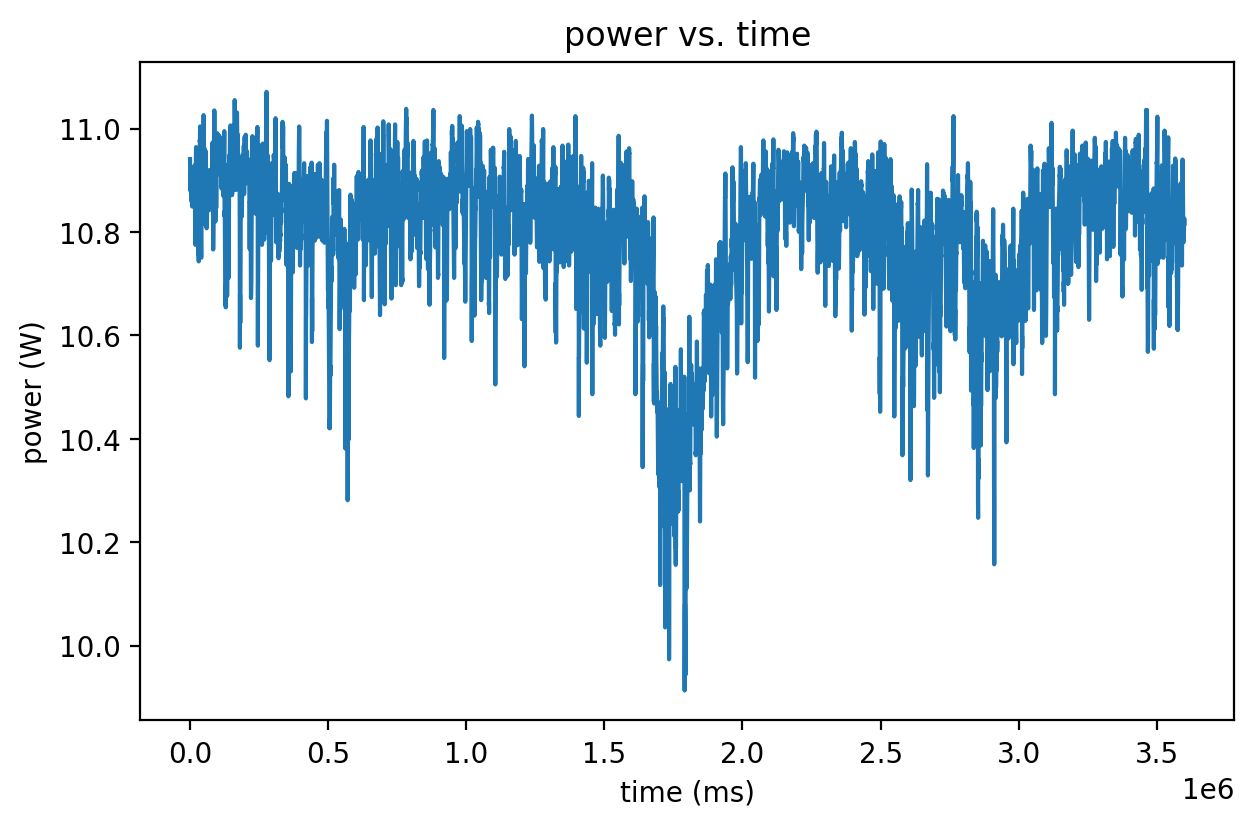

In [11]:
# Power and temp
fig, ax = plt.subplots(dpi=200,figsize=set_size('prl_double_column'))
ax.set_xlabel('time (ms)')
"""ax.plot(analyzer.temperature_time, analyzer.temperature_data)
ycoord = 'temperature'
y_dim = 'C'"""
ax.plot(analyzer.t_power, analyzer.power_data)
ycoord = 'power'
y_dim = 'W'
ax.set_ylabel(ycoord+' (' +y_dim +')')
ax.set_title(ycoord+ ' vs. time')

Text(0.5, 1.0, 'Center of Mass vs. time')

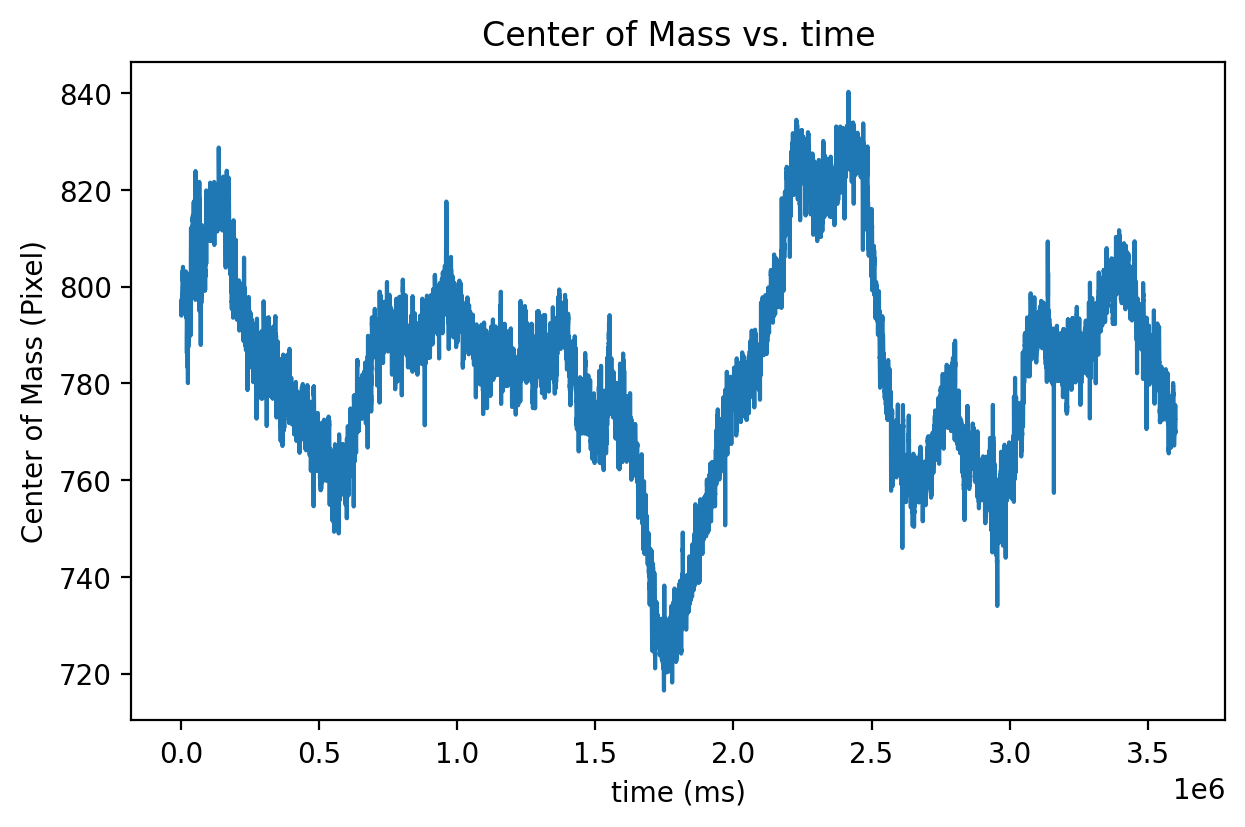

In [12]:
fig, ax = plt.subplots(dpi=200,figsize=set_size('prl_double_column'))
ax.set_xlabel('time (ms)')
# Cam 1
ax.plot(analyzer.t1, analyzer.cam_1_loaded_com[:,0])
ycoord = 'Center of Mass'
y_dim = 'Pixel'

"""ax.plot(analyzer.t1, analyzer.cam_1_intensity)
ycoord = 'intensity'
y_dim = 'arb. units'"""

"""ax.plot(analyzer.t1, analyzer.cam_1_skewness)
ycoord = 'skewness'
y_dim = 'dimensionless'"""

"""ax.plot(analyzer.t1, analyzer.cam_1_gaussian_residual)
ycoord = 'gaussian residual'
y_dim = 'arb. units'"""

"""param_name='sigmax'
param = []
for result in analyzer.cam_1_gaussian_results:
    param.append(result[param_name].value)
ax.plot(analyzer.t1, param)
ycoord = param_name
y_dim = 'arb. units'"""

ax.set_ylabel(ycoord+' (' +y_dim +')')
ax.set_title(ycoord+ ' vs. time')

"""
only run once!
"""
t2_min = analyzer.t2.min()
analyzer._t2 -= t2_min

Text(0.5, 1.0, 'Center of Mass vs. time')

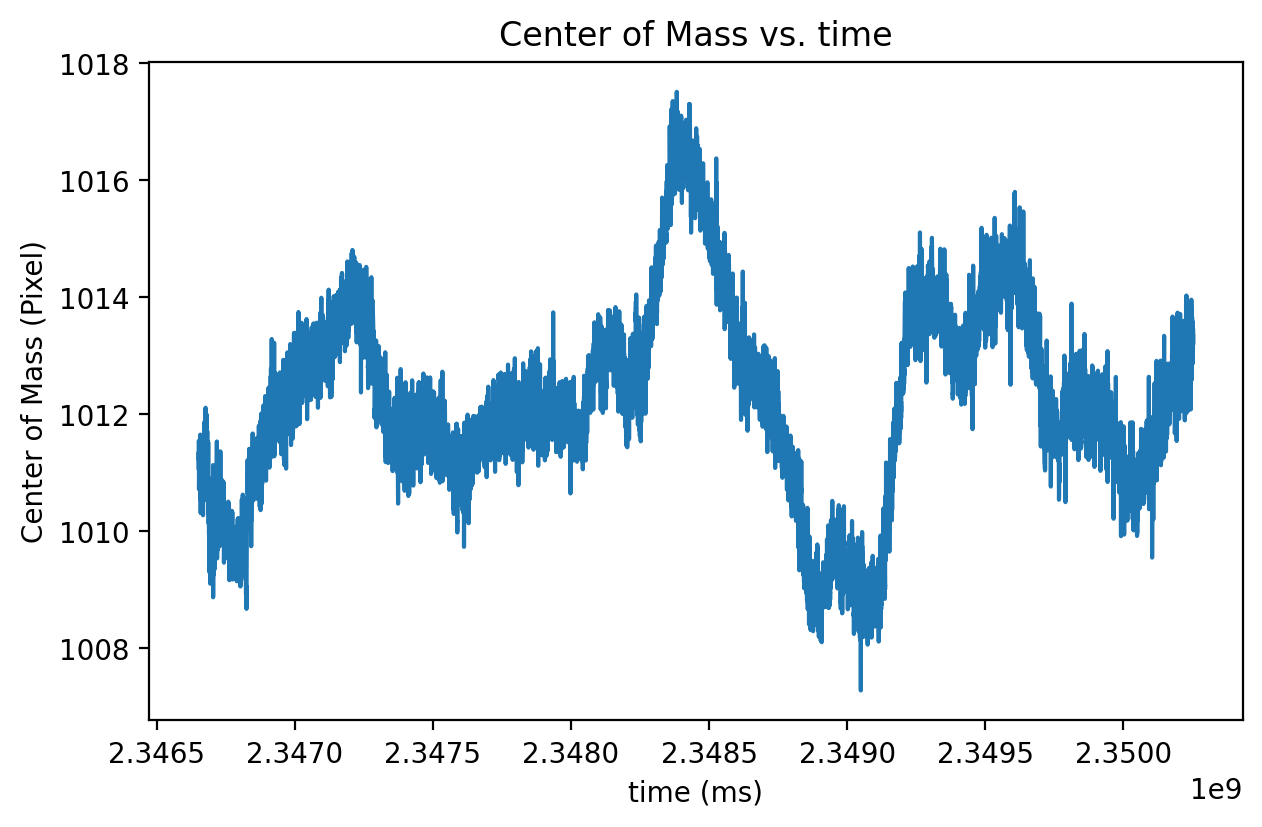

In [13]:
fig, ax = plt.subplots(dpi=200,figsize=set_size('prl_double_column'))
ax.set_xlabel('time (ms)')
# Cam 2
ax.plot(analyzer.t2, analyzer.cam_2_loaded_com[:, 0])
ycoord = 'Center of Mass'
y_dim = 'Pixel'

"""ax.plot(analyzer.t2, analyzer.cam_2_intensity)
ycoord = 'intensity'
y_dim = 'arb. units'"""

"""ax.plot(analyzer.t2, analyzer.cam_2_skewness)
ycoord = 'skewness'
y_dim = 'dimensionless'"""

"""ax.plot(analyzer.t2, analyzer.cam_2_gaussian_residual)
ycoord = 'gaussian residual'
y_dim = 'arb. units'"""

"""param_name='sigmax'
param = []
for result in analyzer.cam_2_gaussian_results:
    param.append(result[param_name].value)
ax.plot(analyzer.t2, param)
ycoord = param_name
y_dim = 'arb. units'"""

ax.set_ylabel(ycoord+' (' +y_dim +')')
ax.set_title(ycoord+ ' vs. time')

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'centerx vs. time')

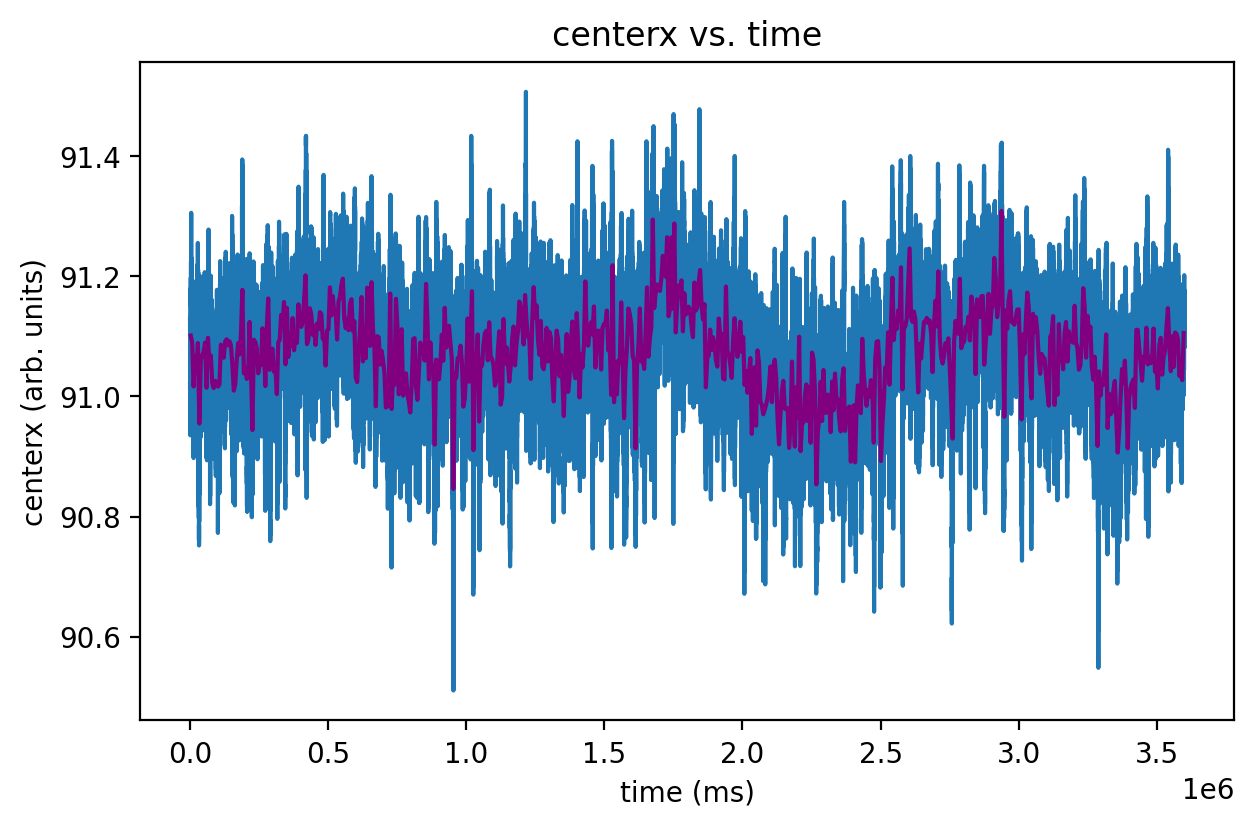

In [19]:
# pump cam
fig, ax = plt.subplots(dpi=200,figsize=set_size('prl_double_column'))
ax.set_xlabel('time (ms)')

"""ax.plot(analyzer.t_pump, analyzer.pump_cam_com[:,0])
ycoord = 'Center of Mass'
y_dim = 'Pixel'"""

"""ax.plot(analyzer.t_pump, analyzer.pump_cam_intensity)
ycoord = 'intensity'
y_dim = 'arb. units'"""

"""ax.plot(analyzer.t_pump, analyzer.pump_cam_skewness)
ycoord = 'skewness'
y_dim = 'dimensionless'"""

"""ax.plot(analyzer.t_pump, analyzer.pump_cam_gaussian_residual)
ycoord = 'gaussian residual'
y_dim = 'arb. units'
"""
param_name='centerx'
param = []
for result in analyzer.pump_cam_gaussian_results:
    param.append(result[param_name].value)
param = np.asarray(param)
ax.plot(analyzer.t_pump, param)
N_ds = 400
ax.plot(np.mean(analyzer.t_pump.reshape(int(analyzer.t_pump.size/N_ds),N_ds), axis=1),np.mean(param.reshape(int(param.size/N_ds),N_ds), axis=1), color='purple')
ycoord = param_name
y_dim = 'arb. units'

ax.set_ylabel(ycoord+' (' +y_dim +')')
ax.set_title(ycoord+ ' vs. time')

In [21]:
f = 200*1000 # um
pixel_pitch = 5.2
dx2_average = np.arctan((param*pixel_pitch)/(f))*10**6 #Convert to microradians
print(dx2_average.max() - dx2_average.min(), dx2_average.std())

25.929286126759052 2.456085464168452


In [15]:
print(np.asarray(analyzer.pump_cam_intensity).std()/np.asarray(analyzer.pump_cam_intensity).mean())

0.019534337590891588


In [16]:
x = []
for params in analyzer.pump_cam_gaussian_results:
    x.append(params['amplitude'].value)
x = np.asarray(x)
print(x.std()/x.mean())

0.011506860223584957


## Between temperature and power

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing correlation at t_offsets: 100%|██████████| 100/100 [00:01<00:00, 76.33offsets/s]


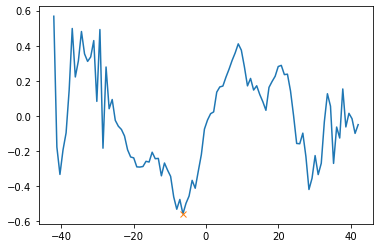

In [29]:
cutoff = 1e-5
t = np.linspace(-0.7*analyzer.temperature_time[-1],0.7*analyzer.temperature_time[-1],100)
corr = analyzer.sweep_t_offset('power_data', 'temperature_data', t_offset=t,  data2_ind=2,
                               frequency_cutoff=cutoff)
fig, ax = plt.subplots()
ax.plot(t/1000/60, corr)
start_ind = 20
ind = np.argmin(corr[start_ind:80])
ind += start_ind
ax.plot(t[ind]/1000/60, corr[ind], marker='x')

-0.5587522972980703 -381818.18181818165


/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


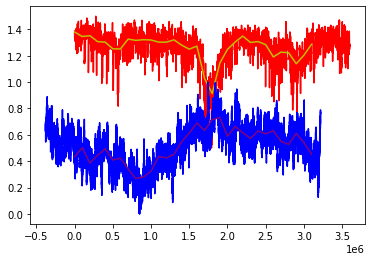

In [30]:
cor, x1, x2, t1, t2, x1_interp, x2_interp, t1_interp, t2_interp = analyzer.get_correlation('power_data', 'temperature_data', t_offset=t[ind],  data2_ind=2,
                               frequency_cutoff=cutoff, get_data=True)
# frequency_cutoff=3.5e-4
fig, ax = plt.subplots()
y1, x1 = analyzer.norm_data(analyzer.power_data, x1, True)
y2, x2 = analyzer.norm_data(analyzer.temperature_data[:,2], x2, True)
ax.plot(analyzer.t_power,y1+0.5, 'r')
ax.plot(t1,x1+0.5, 'y')
ax.plot(analyzer.temperature_time+t[ind],y2, 'b')
ax.plot(t2+t[ind],x2, 'purple')
print(cor, t[ind])

## Temeprature and Wyvern Pointing

In [31]:
cutoff = 3e-5
temp_ind = 2
#t = np.linspace(-0.7*analyzer.t_pump[-1],0.7*analyzer.t_pump[-1],100)
t = np.linspace(-10*60*1000,10*60*1000,100)
corr = analyzer.sweep_t_offset('temperature_data', 'cam_1_loaded_com', t_offset=t, data1_ind=temp_ind , data2_ind=0,
                               frequency_cutoff=cutoff)

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing correlation at t_offsets:   0%|          | 0/100 [00:00<?, ?offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly c

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
Processing correlation at t_offsets:  29%|██▉       | 29/100 [00:00<00:01, 65.75offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnaly

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
Processing correlation at t_offsets:  71%|███████   | 71/100 [00:01<00:00, 64.38offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnaly

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


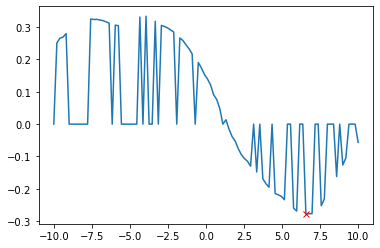

In [33]:
fig, ax = plt.subplots()
corr = np.nan_to_num(corr)
ax.plot(t/1000/60, corr)
start_ind = 40
end_ind = 90
ind = np.argmin(corr[start_ind:end_ind])
ind+= start_ind
ax.plot(t[ind]/1000/60, corr[ind], marker='x', color='r')

-0.277715317847645 393939.39393939404


/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


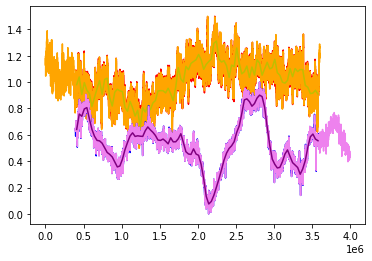

In [34]:
cor, x1, x2, t1, t2, x1_interp, x2_interp, t1_interp, t2_interp = analyzer.get_correlation('temperature_data', 'cam_1_loaded_com', t_offset=t[ind], data1_ind=temp_ind , data2_ind=0,
                               frequency_cutoff=cutoff, get_data=True)
y1 = analyzer.temperature_data[:, temp_ind]
y1 = np.asarray(y1)
fig, ax = plt.subplots()
x1_interp, x1 = analyzer.norm_data(x1_interp, x1, True)
y1 = analyzer.norm_data(y1)
x2_interp, x2 = analyzer.norm_data(x2_interp, x2, True)
y2 = analyzer.norm_data(analyzer.cam_1_loaded_com[:,0])

ax.plot(t1_interp, x1_interp+0.5, 'r')
ax.plot(analyzer.temperature_time, y1+0.5, 'orange')
ax.plot(t1,x1+0.5, 'y')
ax.plot(t2_interp+t[ind], x2_interp, 'b')
ax.plot(analyzer.t1+t[ind], y2, 'violet')
ax.plot(t2+t[ind],x2, 'purple')
print(cor, t[ind])

## Temperature and Pump Pointing

In [14]:
cutoff = 3e-5
temp_ind = 2
#t = np.linspace(-0.7*analyzer.t_pump[-1],0.7*analyzer.t_pump[-1],100)
t = np.linspace(-10*60*1000,10*60*1000,100)
corr = analyzer.sweep_t_offset('temperature_data', 'pump_cam_gaussian_results', t_offset=t, data1_ind=temp_ind , data2_param_name='centerx',
                               frequency_cutoff=cutoff)

Processing correlation at t_offsets:   0%|          | 0/100 [00:00<?, ?offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/p

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
Processing correlation at t_offsets:  29%|██▉       | 29/100 [00:14<00:12,  5.79offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnaly

Processing correlation at t_offsets:  59%|█████▉    | 59/100 [00:25<00:09,  4.15offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
Processing correlation at t_offsets:  60%|██████    | 60/100 [00:26<00:15,  2.63offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
Processing correlation at t_offsets:  61%|██████    | 61/100 [00:26<00:16,  2.35offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filt

Processing correlation at t_offsets:  86%|████████▌ | 86/100 [00:35<00:03,  3.51offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
Processing correlation at t_offsets:  90%|█████████ | 90/100 [00:35<00:01,  7.43offsets/s]/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "
/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditi

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


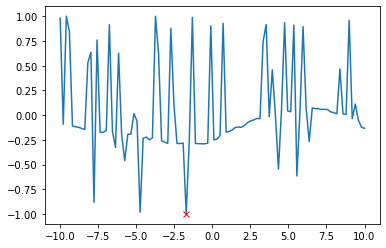

In [15]:
fig, ax = plt.subplots()
corr = np.nan_to_num(corr)
ax.plot(t/1000/60, corr)
start_ind = 0
end_ind = 70
ind = np.argmin(corr[start_ind:end_ind])
ind+= start_ind
ax.plot(t[ind]/1000/60, corr[ind], marker='x', color='r')

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.2693088767006146 -103030.30303030298


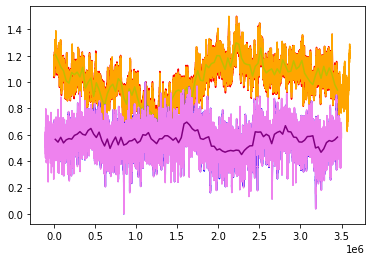

In [16]:
cor, x1, x2, t1, t2, x1_interp, x2_interp, t1_interp, t2_interp = analyzer.get_correlation('temperature_data', 'pump_cam_gaussian_results', t_offset=t[ind], data1_ind=temp_ind , data2_param_name='centerx',
                               frequency_cutoff=cutoff, get_data=True)
y1 = analyzer.temperature_data[:, temp_ind]
y1 = np.asarray(y1)
fig, ax = plt.subplots()
x1_interp, x1 = analyzer.norm_data(x1_interp, x1, True)
y1 = analyzer.norm_data(y1)
x2_interp, x2 = analyzer.norm_data(x2_interp, x2, True)
y2 = []
for result in analyzer.pump_cam_gaussian_results:
    y2.append(result['centerx'].value)
y2 = np.asarray(y2)
y2 = analyzer.norm_data(y2)

ax.plot(t1_interp, x1_interp+0.5, 'r')
ax.plot(analyzer.temperature_time, y1+0.5, 'orange')
ax.plot(t1,x1+0.5, 'y')
ax.plot(t2_interp+t[ind], x2_interp, 'b')
ax.plot(analyzer.t_pump+t[ind], y2, 'violet')
ax.plot(t2+t[ind],x2, 'purple')
print(cor, t[ind])

## Now pump pointing with Wyvern Pointing (cam 1) vertical component

#### pump as COM

In [49]:
cutoff = 1e-5
t = np.linspace(-0.7*analyzer.t_pump[-1],0.7*analyzer.t_pump[-1],100)
corr = analyzer.sweep_t_offset('pump_cam_com', 'cam_1_loaded_com', t_offset=t,  data1_ind=0, data2_ind=0,
                               frequency_cutoff=cutoff)

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Processing correlation at t_offsets:   0%|          | 0/100 [00:00<?, ?offsets/s]

averaging!
averaging!
averaging!


/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/scipy/signal/_filter_design.py:1709: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:   1%|          | 1/100 [00:06<10:32,  6.39s/offsets]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:   4%|▍         | 4/100 [00:06<02:06,  1.31s/offsets]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:   5%|▌         | 5/100 [00:07<01:53,  1.19s/offsets]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  15%|█▌        | 15/100 [00:12<00:53,  1.59offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  17%|█▋        | 17/100 [00:13<00:46,  1.79offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  19%|█▉        | 19/100 [00:14<00:44,  1.81offsets/s]

averaging!
averaging!
averaging!


Processing correlation at t_offsets:  21%|██        | 21/100 [00:14<00:36,  2.19offsets/s]

averaging!
averaging!
averaging!


Processing correlation at t_offsets:  28%|██▊       | 28/100 [00:15<00:19,  3.73offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  29%|██▉       | 29/100 [00:18<00:44,  1.60offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  30%|███       | 30/100 [00:19<00:44,  1.56offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  33%|███▎      | 33/100 [00:20<00:35,  1.91offsets/s]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  37%|███▋      | 37/100 [00:20<00:21,  2.97offsets/s]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  38%|███▊      | 38/100 [00:21<00:23,  2.67offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  39%|███▉      | 39/100 [00:22<00:24,  2.52offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  42%|████▏     | 42/100 [00:22<00:15,  3.67offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  43%|████▎     | 43/100 [00:26<00:50,  1.12offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  45%|████▌     | 45/100 [00:27<00:39,  1.39offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  47%|████▋     | 47/100 [00:27<00:28,  1.87offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  48%|████▊     | 48/100 [00:27<00:25,  2.07offsets/s]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  49%|████▉     | 49/100 [00:28<00:27,  1.83offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  54%|█████▍    | 54/100 [00:29<00:14,  3.13offsets/s]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  55%|█████▌    | 55/100 [00:30<00:17,  2.64offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  57%|█████▋    | 57/100 [00:34<00:38,  1.13offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  58%|█████▊    | 58/100 [00:34<00:33,  1.24offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  59%|█████▉    | 59/100 [00:34<00:28,  1.44offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  60%|██████    | 60/100 [00:35<00:29,  1.35offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  63%|██████▎   | 63/100 [00:36<00:20,  1.78offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  68%|██████▊   | 68/100 [00:38<00:12,  2.49offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  69%|██████▉   | 69/100 [00:38<00:12,  2.47offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  70%|███████   | 70/100 [00:39<00:11,  2.57offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  71%|███████   | 71/100 [00:41<00:24,  1.18offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  72%|███████▏  | 72/100 [00:42<00:26,  1.06offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  76%|███████▌  | 76/100 [00:43<00:12,  1.95offsets/s]

averaging!
averaging!
averaging!


Processing correlation at t_offsets:  78%|███████▊  | 78/100 [00:43<00:09,  2.42offsets/s]

averaging!
averaging!
averaging!


Processing correlation at t_offsets:  80%|████████  | 80/100 [00:44<00:07,  2.57offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  81%|████████  | 81/100 [00:45<00:08,  2.36offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  82%|████████▏ | 82/100 [00:45<00:06,  2.57offsets/s]

averaging!
averaging!
averaging!


Processing correlation at t_offsets:  83%|████████▎ | 83/100 [00:45<00:05,  2.90offsets/s]

averaging!


Processing correlation at t_offsets:  84%|████████▍ | 84/100 [00:46<00:06,  2.60offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  85%|████████▌ | 85/100 [00:48<00:12,  1.21offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  86%|████████▌ | 86/100 [00:48<00:10,  1.36offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  87%|████████▋ | 87/100 [00:49<00:09,  1.42offsets/s]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  88%|████████▊ | 88/100 [00:49<00:06,  1.77offsets/s]

averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  91%|█████████ | 91/100 [00:50<00:03,  2.61offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets:  94%|█████████▍| 94/100 [00:50<00:01,  3.72offsets/s]

averaging!
averaging!


Processing correlation at t_offsets:  95%|█████████▌| 95/100 [00:51<00:01,  3.59offsets/s]

averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!
averaging!


Processing correlation at t_offsets: 100%|██████████| 100/100 [00:51<00:00,  1.95offsets/s]

averaging!
averaging!
averaging!
averaging!


/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


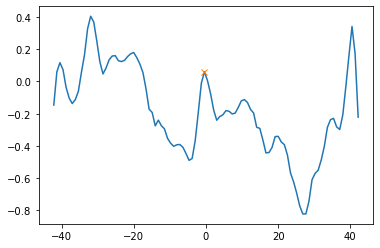

In [50]:
fig, ax = plt.subplots()
ax.plot(t/1000/60, corr)
start_ind = 40
end_ind = 70
ind = np.argmax(corr[start_ind:end_ind])
ind+= start_ind
ax.plot(t[ind]/1000/60, corr[ind], marker='x')

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


averaging!
averaging!
0.06095348675693828 -25560.146923783235


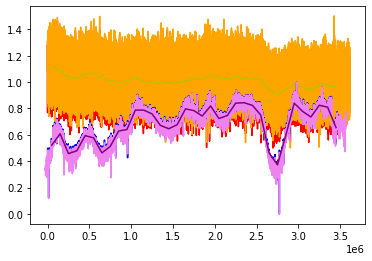

In [51]:
cor, x1, x2, t1, t2, x1_interp, x2_interp, t1_interp, t2_interp = analyzer.get_correlation('pump_cam_com', 'cam_1_loaded_com', t_offset=t[ind],  data1_ind=0, data2_ind=0,
                               frequency_cutoff=cutoff, get_data=True)

fig, ax = plt.subplots()
x1_interp, x1 = analyzer.norm_data(x1_interp, x1, True)
y1 = analyzer.norm_data(analyzer.pump_cam_com[:,0])
x2_interp, x2 = analyzer.norm_data(x2_interp, x2, True)
y2 = analyzer.norm_data(analyzer.cam_1_loaded_com[:,0])
ax.plot(t1_interp, x1_interp+0.5, 'r')
ax.plot(analyzer.t_pump, y1+0.5, 'orange')
ax.plot(t1,x1+0.5, 'y')
ax.plot(t2_interp+t[ind], x2_interp, 'b')
ax.plot(analyzer.t1+t[ind], y2, 'violet')
ax.plot(t2+t[ind],x2, 'purple')
print(cor, t[ind])

#### pump as gaussian center

In [11]:
#cutoff = 1e-4
cutoff = 2e-4
#t = np.linspace(-0.7*analyzer.t_pump[-1],0.7*analyzer.t_pump[-1],100)
t = np.linspace(-10*60*1000,10*60*1000,100)
corr = analyzer.sweep_t_offset('pump_cam_gaussian_results', 'cam_1_loaded_com', t_offset=t, data1_param_name='centerx' , data2_ind=0,
                               frequency_cutoff=cutoff)

Processing correlation at t_offsets: 100%|██████████| 100/100 [00:41<00:00,  2.43offsets/s]


/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


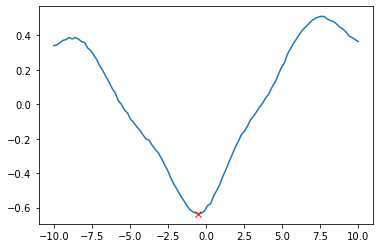

In [12]:
fig, ax = plt.subplots()
if np.any(np.isnan(corr)):
    print("There was a Nan")
corr = np.nan_to_num(corr)
ax.plot(t/1000/60, corr)
start_ind = 40
end_ind = 60
ind = np.argmin(corr[start_ind:end_ind])
ind+= start_ind
ax.plot(t[ind]/1000/60, corr[ind], marker='x', color='r')

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-0.6369586557777427 -30303.030303030275


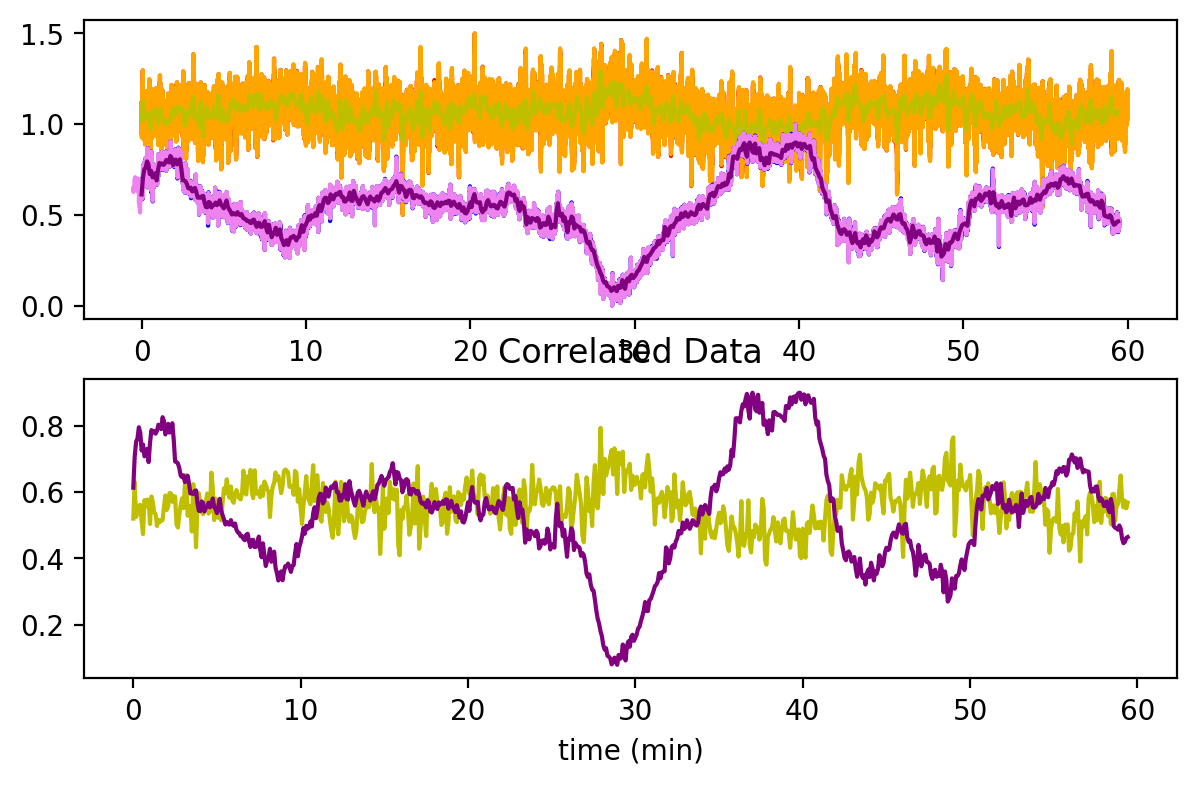

In [13]:
cor, x1, x2, t1, t2, x1_interp, x2_interp, t1_interp, t2_interp = analyzer.get_correlation('pump_cam_gaussian_results', 'cam_1_loaded_com', t_offset=t[ind], data1_param_name='centerx' , data2_ind=0,
                               frequency_cutoff=cutoff, get_data=True)
y1 = []
for result in analyzer.pump_cam_gaussian_results:
    y1.append(result['centerx'].value)
y1 = np.asarray(y1)
fig, ax = plt.subplots(2,1, figsize=set_size('prl_double_column'), dpi=200)
x1_interp, x1 = analyzer.norm_data(x1_interp, x1, True)
y1 = analyzer.norm_data(y1)
x2_interp, x2 = analyzer.norm_data(x2_interp, x2, True)
y2 = analyzer.norm_data(analyzer.cam_1_loaded_com[:,0])
ax[0].plot((t1_interp)/(60*1000), x1_interp+0.5, 'r')
ax[0].plot((analyzer.t_pump)/(60*1000), y1+0.5, 'orange')
ax[0].plot((t1)/(60*1000),x1+0.5, 'y')
ax[0].plot((t2_interp+t[ind])/(60*1000), x2_interp, 'b')
ax[0].plot((analyzer.t1+t[ind])/(60*1000), y2, 'violet')
ax[0].plot((t2+t[ind])/(60*1000),x2, 'purple')

ax[1].plot((t1)/(60*1000),x1, 'y')
ax[1].plot((t2+t[ind])/(60*1000),x2, 'purple')

ax[1].set_title('Correlated Data')
ax[1].set_xlabel('time (min)')
print(cor, t[ind])

/Users/glinn/opt/anaconda3/envs/PointLockAnalysis/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


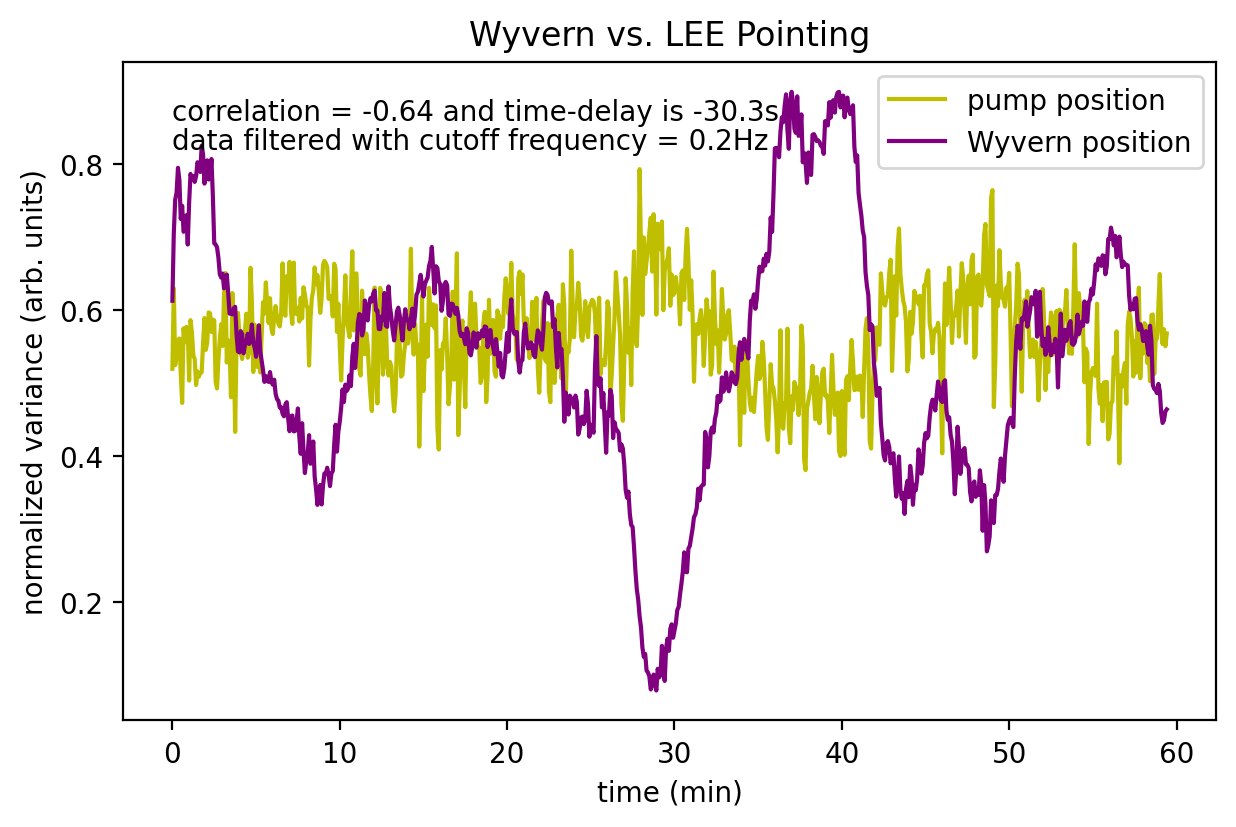

In [17]:
fig, ax = plt.subplots(dpi=200, figsize=set_size('prl_double_column'))
ax.plot((t1)/(60*1000),x1, 'y')
ax.plot((t2+t[ind])/(60*1000),x2, 'purple')
ax.set_title('Wyvern vs. LEE Pointing')
ax.set_xlabel('time (min)')
ax.set_ylabel('normalized variance (arb. units)')
ax.legend(['pump position', 'Wyvern position'])
ax.annotate('correlation = ' + str(np.round(cor,decimals=2))+ ' and time-delay is '
            + str(np.round(t[ind]/1000, decimals=2))+ 's', (0,0.86))
ax.annotate('data filtered with cutoff frequency = ' +str(cutoff*1000) + 'Hz', (0, 0.82))
plt.savefig(r'/Users/glinn/Google Drive (anli2171@colorado.edu)/Dessau Lab/Code/PointLock Software/Pointing Analysis/acq5-8-8-23.pdf')

# Let's calculate some time-series data from the videos (unless already done and loaded, then skip?)

## COM coordinates for the cameras

In [ ]:
#Cam 1
analyzer.get_com_from_video(1, num_frames_in_batch=5000)

In [ ]:
#Cam 2
analyzer.get_com_from_video(2)

In [8]:
#pump cam
analyzer.get_com_from_video(3)

Processing Frames: 100%|██████████| 277200/277200 [01:40<00:00, 2768.70frame/s]


In [ ]:
analyzer.get_length_of_video(3)

## Intensities of the frames in the videos

In [9]:
#Cam 1
analyzer.get_intensity(1, num_reports= 1, num_frames_in_batch = 5000)

Processing Frames: 100%|██████████| 49016/49016 [05:56<00:00, 137.33frame/s] 

percent complete:  100.0 total frames:  49016
time to complete chunk is  356.62478483300004
time to complete all processing is  356.624799458


In [10]:
#Cam 2
analyzer.get_intensity(2, num_reports= 1, num_frames_in_batch = 5000)

Processing Frames: 100%|██████████| 49011/49011 [04:18<00:00, 189.70frame/s] 

percent complete:  100.0 total frames:  49011
time to complete chunk is  258.090526083
time to complete all processing is  258.09054587499986


In [11]:
#pump cam
analyzer.get_intensity(3, num_reports= 1, num_frames_in_batch = 5000)

Processing Frames: 100%|██████████| 277200/277200 [01:04<00:00, 4285.23frame/s]

percent complete:  100.0 total frames:  277200
time to complete chunk is  64.68793883399985
time to complete all processing is  64.68795370899988


## Skewness

In [12]:
#Cam 1 
analyzer.get_skewness(cam_num=1, num_reports=10, num_frames_in_batch=5000)

Processing Frames:  10%|█         | 4927/49016 [00:29<04:33, 161.02frame/s]

percent complete:  10.0 total frames:  49016
time to complete chunk is  62.07465504200013


Processing Frames:  20%|██        | 9824/49016 [01:32<03:35, 182.08frame/s] 

percent complete:  20.0 total frames:  49016
time to complete chunk is  62.71841491700002


Processing Frames:  30%|███       | 14729/49016 [02:33<03:28, 164.64frame/s] 

percent complete:  30.0 total frames:  49016
time to complete chunk is  60.7350966250001


Processing Frames:  40%|████      | 19614/49016 [03:35<03:20, 146.79frame/s] 

percent complete:  40.0 total frames:  49016
time to complete chunk is  62.53148075000013


Processing Frames:  50%|█████     | 24528/49016 [05:50<02:18, 176.55frame/s]  

percent complete:  50.0 total frames:  49016
time to complete chunk is  64.54329804199983


Processing Frames:  60%|██████    | 29435/49016 [06:53<01:51, 174.96frame/s] 

percent complete:  60.0 total frames:  49016
time to complete chunk is  62.781796374999885


Processing Frames:  70%|███████   | 34327/49016 [07:56<01:28, 165.31frame/s] 

percent complete:  70.0 total frames:  49016
time to complete chunk is  63.05465262500002


Processing Frames:  80%|████████  | 39231/49016 [08:59<00:57, 168.95frame/s] 

percent complete:  80.0 total frames:  49016
time to complete chunk is  62.70589733299994


Processing Frames:  90%|█████████ | 44134/49016 [10:01<00:28, 170.85frame/s] 

percent complete:  90.0 total frames:  49016
time to complete chunk is  62.49961362499994


Processing Frames: 100%|█████████▉| 49010/49016 [10:57<00:00, 176.71frame/s]

percent complete:  100.0 total frames:  49016
time to complete chunk is  55.89778237500013
percent complete:  100.0 total frames:  49016
time to complete chunk is  0.00108416600005512
time to complete all processing is  619.546413042


Processing Frames: 100%|██████████| 49016/49016 [10:57<00:00, 74.51frame/s] 


In [13]:
#Cam 2 
analyzer.get_skewness(cam_num=2, num_reports=10, num_frames_in_batch=5000)

Processing Frames:  10%|█         | 4923/49011 [00:28<04:33, 161.26frame/s]

percent complete:  10.0 total frames:  49011
time to complete chunk is  52.190776125000184


Processing Frames:  20%|██        | 9820/49011 [01:20<04:25, 147.79frame/s] 

percent complete:  20.0 total frames:  49011
time to complete chunk is  52.191390875000025


Processing Frames:  30%|███       | 14724/49011 [02:12<03:13, 177.46frame/s] 

percent complete:  30.0 total frames:  49011
time to complete chunk is  52.14858445899995


Processing Frames:  40%|████      | 19635/49011 [03:04<03:04, 159.63frame/s] 

percent complete:  40.0 total frames:  49011
time to complete chunk is  51.96300233299985


Processing Frames:  50%|█████     | 24527/49011 [03:56<02:30, 162.24frame/s] 

percent complete:  50.0 total frames:  49011
time to complete chunk is  51.91943195800013


Processing Frames:  60%|██████    | 29436/49011 [04:49<01:56, 167.63frame/s] 

percent complete:  60.0 total frames:  49011
time to complete chunk is  52.584338666999884


Processing Frames:  70%|███████   | 34330/49011 [21:59<01:20, 182.93frame/s]  

percent complete:  70.0 total frames:  49011
time to complete chunk is  51.82167537499981


Processing Frames:  80%|████████  | 39227/49011 [36:43<00:59, 164.48frame/s]  

percent complete:  80.0 total frames:  49011
time to complete chunk is  52.14536979100012


Processing Frames:  90%|█████████ | 44143/49011 [53:44<00:28, 172.75frame/s]  

percent complete:  90.0 total frames:  49011
time to complete chunk is  52.13458212500018


Processing Frames: 100%|██████████| 49011/49011 [56:51<00:00, 14.37frame/s] 

percent complete:  100.0 total frames:  49011
time to complete chunk is  47.97075187499968
percent complete:  100.0 total frames:  49011
time to complete chunk is  4.733300011139363e-05
time to complete all processing is  517.0718362080001


In [14]:
#pump cam 
analyzer.get_skewness(cam_num=3, num_reports=10, num_frames_in_batch=5000)

Processing Frames:  10%|█         | 28076/277200 [00:18<01:53, 2199.37frame/s]

percent complete:  10.0 total frames:  277200
time to complete chunk is  19.382290832999843


Processing Frames:  20%|██        | 55767/277200 [00:37<03:20, 1106.72frame/s]

percent complete:  20.0 total frames:  277200
time to complete chunk is  18.53740975000028


Processing Frames:  30%|███       | 83382/277200 [00:54<01:26, 2244.81frame/s]

percent complete:  30.0 total frames:  277200
time to complete chunk is  17.43420974999981


Processing Frames:  40%|████      | 111321/277200 [01:12<01:50, 1503.38frame/s]

percent complete:  40.0 total frames:  277200
time to complete chunk is  18.27932616599992


Processing Frames:  50%|█████     | 138927/277200 [01:30<01:02, 2228.41frame/s]

percent complete:  50.0 total frames:  277200
time to complete chunk is  17.43943854200006


Processing Frames:  60%|██████    | 166668/277200 [01:48<00:59, 1866.34frame/s]

percent complete:  60.0 total frames:  277200
time to complete chunk is  18.658033624999916


Processing Frames:  70%|███████   | 194270/277200 [02:06<00:36, 2266.02frame/s]

percent complete:  70.0 total frames:  277200
time to complete chunk is  17.450281542000084


Processing Frames:  80%|████████  | 222123/277200 [02:24<00:26, 2078.55frame/s]

percent complete:  80.0 total frames:  277200
time to complete chunk is  18.48815470799991


Processing Frames:  90%|█████████ | 249730/277200 [02:42<00:12, 2261.76frame/s]

percent complete:  90.0 total frames:  277200
time to complete chunk is  17.459249916999852


Processing Frames: 100%|██████████| 277200/277200 [03:00<00:00, 1539.35frame/s]


percent complete:  100.0 total frames:  277200
time to complete chunk is  17.884032458000092
time to complete all processing is  181.0197342919996


## Gaussian Fits

In [ ]:
# Cam1: Prep initial conditions for fit
analyzer._cam_1_video.set(cv2.CAP_PROP_POS_FRAMES, 1-1)
res, frame = analyzer._cam_1_video.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
i0 = {'amplitude': 200000*frame.max(), 'centerx': 1050, 'centery': 730,
                                     'sigmax': 190, 'sigmay': 180}
par = analyzer.gaussian_model.make_params()
for key in i0.keys():
    par[key].value = i0[key]
analyzer._cam_1_video.set(cv2.CAP_PROP_POS_FRAMES, 1-1)
analyzer._cam_1_video.get(cv2.CAP_PROP_POS_FRAMES)

X, Y = np.meshgrid(np.arange(frame.shape[1]), np.arange(frame.shape[0]))
fig, ax = plt.subplots(1,2, dpi=200)
#frame = np.asarray(frame, dtype=float)
ax[0].imshow(frame)
ax[1].imshow(frame - analyzer.gaussian_model.eval(par, x=X, y=Y))

In [ ]:
# Cam1: fit
analyzer.fit_gaussians(1, i0, get_residuals=True, num_reports=1, num_frames_in_batch=3000)

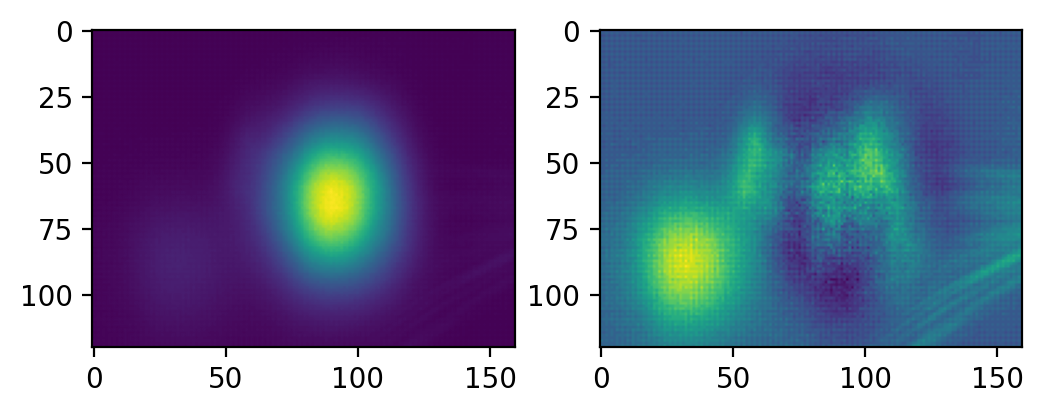

In [15]:
# pump cam: prep initial conditions
analyzer.pump_video.set(cv2.CAP_PROP_POS_FRAMES, 1-1)
res, frame = analyzer.pump_video.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
i0 = {'amplitude': 1800*frame.max(), 'centerx': 91, 'centery': 65,
                                     'sigmax': 15, 'sigmay': 20}
par = analyzer.gaussian_model.make_params()
for key in i0.keys():
    par[key].value = i0[key]
analyzer.pump_video.set(cv2.CAP_PROP_POS_FRAMES, 1-1)
analyzer.pump_video.get(cv2.CAP_PROP_POS_FRAMES)

X, Y = np.meshgrid(np.arange(frame.shape[1]), np.arange(frame.shape[0]))
fig, ax = plt.subplots(1,2, dpi=200)
#frame = np.asarray(frame, dtype=float)
ax[0].imshow(frame)
ax[1].imshow(frame - analyzer.gaussian_model.eval(par, x=X, y=Y))

In [16]:
analyzer.fit_gaussians(3, i0, get_residuals=True, num_reports=1, num_frames_in_batch=3000)

Processing Frames: 100%|█████████▉| 277199/277200 [36:10<00:00, 127.69frame/s] 


percent complete:  100.0 total frames:  277200
time to complete chunk is  2162.681871084
time to complete all processing is  2162.681888626


## Store the data!

In [17]:
# This saves all of the results of the long timescale calculations above.
results_directory = acquisition_folder_path+'_results'
analyzer.save_all_attributes(results_directory)

no data for property,  cam_1_com , so nothing saved for this property.
no data for property,  cam_2_com , so nothing saved for this property.
no data for property,  cam_1_gaussian_results , so nothing saved for this property.
no data for property,  cam_2_gaussian_results , so nothing saved for this property.
no data for property,  cam_1_gaussian_residual , so nothing saved for this property.
no data for property,  cam_2_gaussian_residual , so nothing saved for this property.
